In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras import layers, models, optimizers, utils
import tensorflow as tf
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)

In [2]:
benign_dir = '/kaggle/input/skin-cancer-isic-images/benign'
malignant_dir = '/kaggle/input/skin-cancer-isic-images/malignant'

benign_images = os.listdir(benign_dir)
malignant_images = os.listdir(malignant_dir)


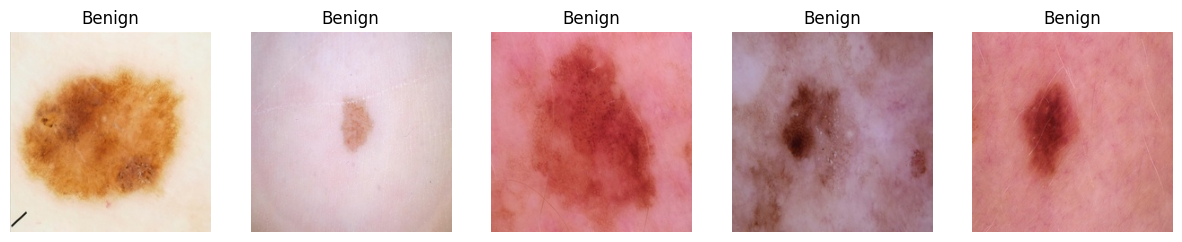

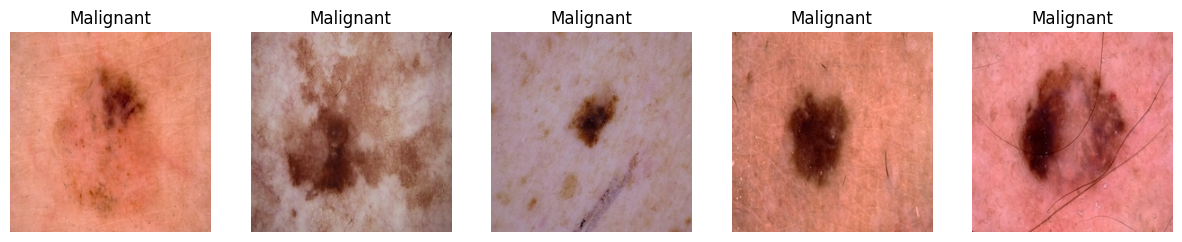

In [3]:
def display_sample_images(image_list, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img_path = os.path.join(benign_dir if title == 'Benign' else malignant_dir, image_list[i])
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

display_sample_images(benign_images, 'Benign')
display_sample_images(malignant_images, 'Malignant')


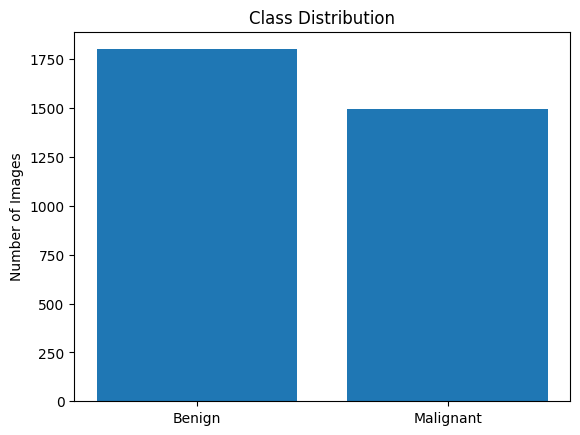

In [4]:
class_counts = {'Benign': len(benign_images), 'Malignant': len(malignant_images)}
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

In [5]:
img_height, img_width = 128, 128
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-isic-images',
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer-isic-images',
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

Found 2638 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [6]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from keras import optimizers, callbacks

# Define the ReduceLROnPlateau callback
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when the learning rate is reduced
)


checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',     # Path to save the model file
    monitor='val_loss',  # Monitor the validation loss
    save_best_only=True, # Save only the best model
    mode='min',          # Save the model with the minimum validation loss
    verbose=1            # Print a message when the model is saved
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print a message when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


In [8]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
num_epochs = 30
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731931608.197203     112 service.cc:145] XLA service 0x7cbb1800c5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731931608.197277     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731931608.197283     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/83 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - accuracy: 0.5938 - loss: 0.6914

I0000 00:00:1731931613.175506     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5420 - loss: 0.6929
Epoch 1: val_loss improved from inf to 0.68880, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 409ms/step - accuracy: 0.5421 - loss: 0.6929 - val_accuracy: 0.5645 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/30
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5999 - loss: 0.6748
Epoch 2: val_loss improved from 0.68880 to 0.64866, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.6005 - loss: 0.6744 - val_accuracy: 0.6434 - val_loss: 0.6487 - learning_rate: 0.0010
Epoch 3/30
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6345 - loss: 0.6469
Epoch 3: val_loss improved from 0.64866 to 0.64527, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.6348 - loss: 0.6468 - val_accuracy: 0.6328 - val_loss: 0.6453 - learning_rate: 0.0010
Epoch 4/30
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6545 - los

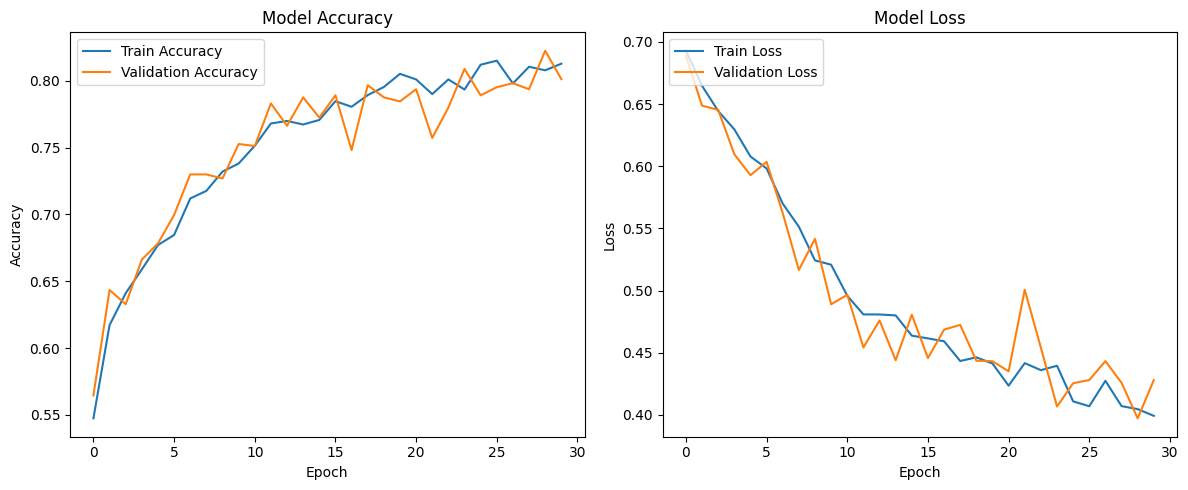

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
Accuracy: 0.8073
Precision: 0.7774
Recall: 0.8060
F1 Score: 0.7915


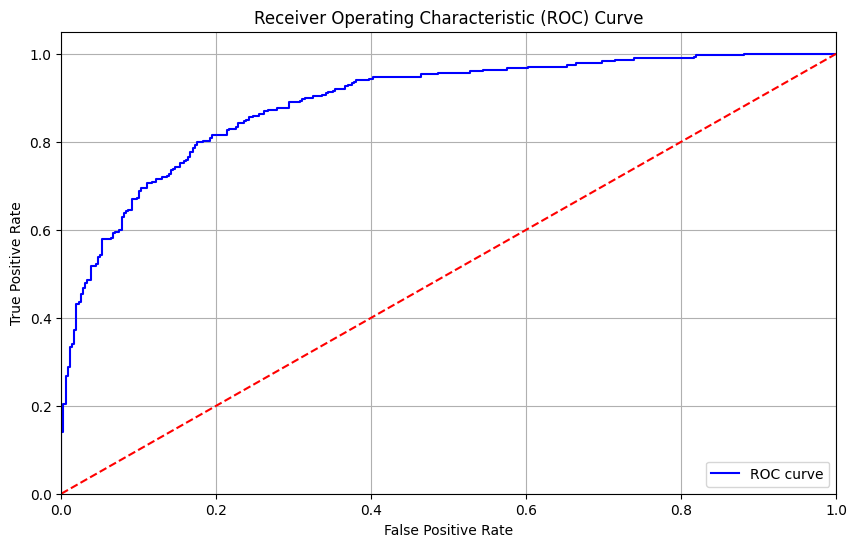

In [12]:

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


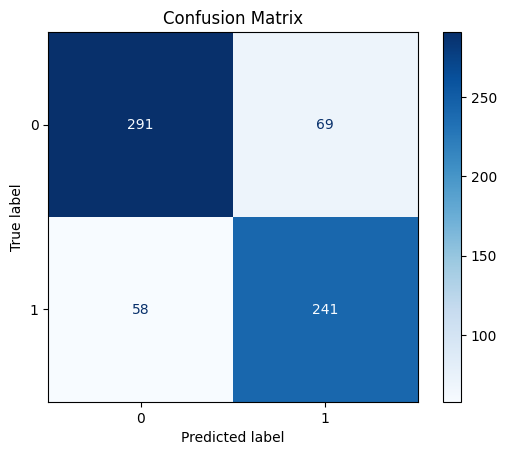

In [13]:

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Improved model

In [117]:
train_generator.reset()
validation_generator.reset()

In [132]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when the learning rate is reduced
)


checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',     # Path to save the model file
    monitor='val_loss',  # Monitor the validation loss
    save_best_only=True, # Save only the best model
    mode='min',          # Save the model with the minimum validation loss
    verbose=1            # Print a message when the model is saved
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print a message when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


In [134]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_136 (Conv2D)             │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 124, 124, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 58, 58, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 58, 58, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,441 (1.63 MB)

 Trainable params: 426,961 (1.63 MB)

 Non-trainable params: 480 (1.88 KB)

In [136]:
num_epochs = 50
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5245 - loss: 0.9648
Epoch 1: val_loss improved from inf to 0.72402, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - accuracy: 0.5249 - loss: 0.9634 - val_accuracy: 0.5463 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 2/50
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6308 - loss: 0.7241
Epoch 2: val_loss did not improve from 0.72402
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.6307 - loss: 0.7238 - val_accuracy: 0.5463 - val_loss: 0.8002 - learning_rate: 0.0010
Epoch 3/50
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6279 - loss: 0.7030
Epoch 3: val_loss improved from 0.72402 to 0.68215, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.6281 - loss: 0.7023 - val_accuracy: 0.5766 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 4/50
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6419 - loss: 0.6493
Epoch 4: val_loss

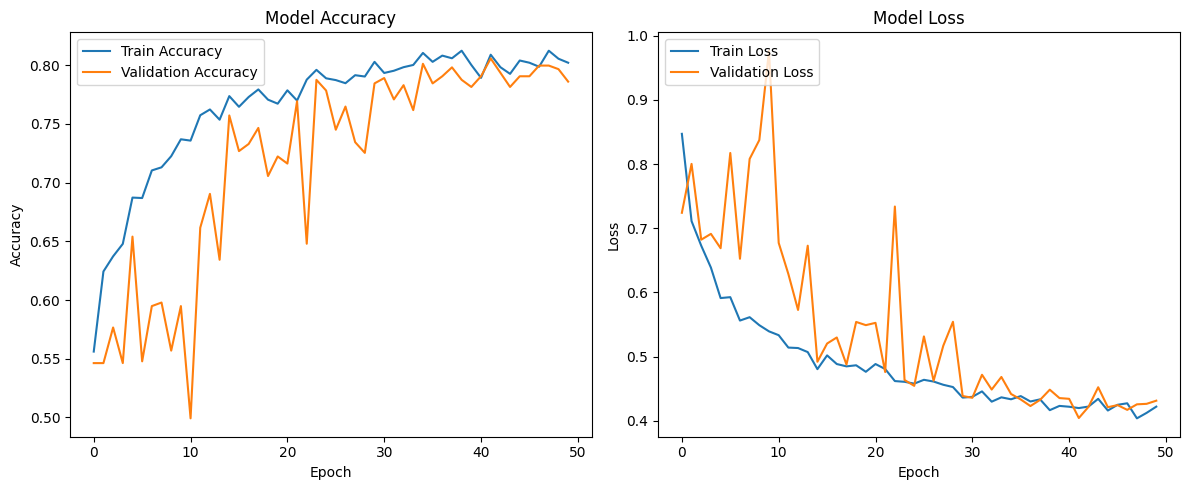

In [137]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [138]:
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
Accuracy: 0.8042
Precision: 0.7545
Recall: 0.8428
F1 Score: 0.7962


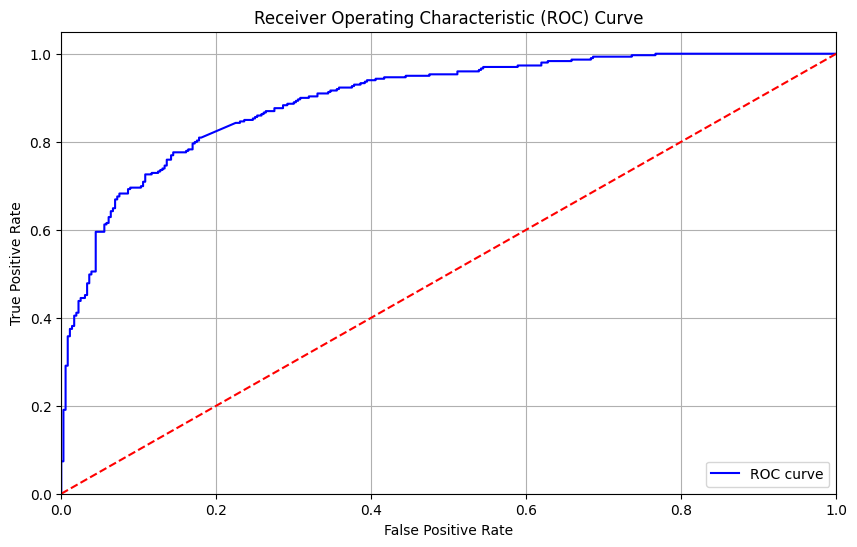

In [139]:

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


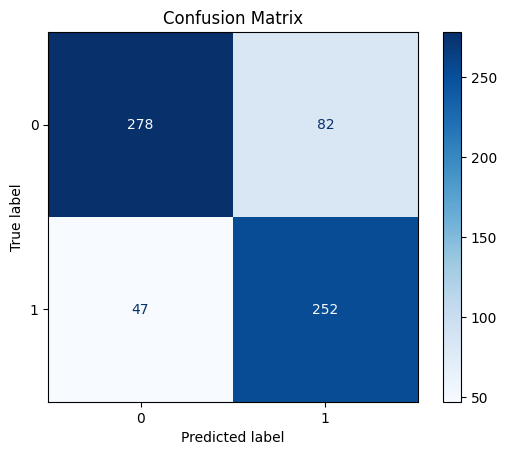

In [140]:

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
